In [2]:
num_parties = 2  ## number of participating parties
dataset = 'mnist'

# Gerando a base de dados para os modelos existentes na ferramenta

Para executar o aprendizado federado da IBM, você deve ter arquivos de configuração para o agregador e para cada parte.

A ferramenta da **IBM** possui alguns datasets já configurados a título de exemplificação. Para todos esses exemplos, existe um arquivo **generate_data.py** para que possamos particionar a base de dados a partir dos seguintes sinalizadores: 

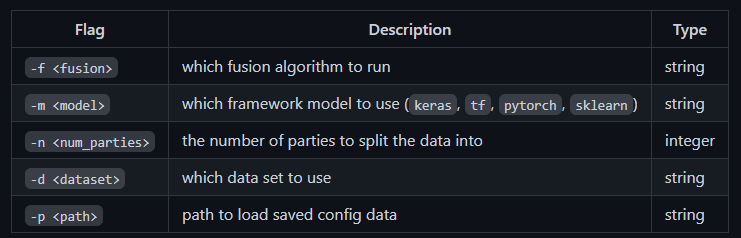

In [3]:
%run examples/generate_data.py -n $num_parties -d $dataset -pp 200 

Party_ 0
nb_x_train:  (200, 28, 28) nb_x_test:  (5000, 28, 28)
* Label  0  samples:  27
* Label  1  samples:  15
* Label  2  samples:  16
* Label  3  samples:  18
* Label  4  samples:  19
* Label  5  samples:  16
* Label  6  samples:  13
* Label  7  samples:  32
* Label  8  samples:  19
* Label  9  samples:  25
Finished! :) Data saved in  examples/data/mnist/random
Party_ 1
nb_x_train:  (200, 28, 28) nb_x_test:  (5000, 28, 28)
* Label  0  samples:  24
* Label  1  samples:  19
* Label  2  samples:  24
* Label  3  samples:  21
* Label  4  samples:  18
* Label  5  samples:  18
* Label  6  samples:  18
* Label  7  samples:  24
* Label  8  samples:  17
* Label  9  samples:  17
Finished! :) Data saved in  examples/data/mnist/random


# Definição do modelo

Na célula a seguir deve-se especificar as configurações do modelo para a base de dados que se deseja trabalhar. Ao executar tal célula, o modelo será gerado, compilado e salvo para uso futuro.

Com a ferramenta da **IBM** é possível gerar modelos para as principais ferramentas do mercado. Como por exemplo, **Keras**, **Pytorch**, **Sklearn** e **TensorFlow**.

**OBS:.** O exemplo a seguir consiste no modelo para treinamento do **Mnist** com **Keras**.

In [4]:
import os

import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
def save_model_config(folder_configs):
    num_classes = 10
    img_rows, img_cols = 28, 28
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_rows, img_cols)
    else:
        input_shape = (img_rows, img_cols, 1)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    if not os.path.exists(folder_configs):
        os.makedirs(folder_configs)

    # Save model
    fname = os.path.join(folder_configs, 'compiled_keras.h5')
    model.save(fname)
    print(fname)

    K.clear_session()
    # Generate model spec:
    spec = {
        'model_name': 'keras-cnn',
        'model_definition': fname
    }

    model = {
        'name': 'KerasFLModel',
        'path': 'ibmfl.model.keras_fl_model',
        'spec': spec
    }

    return model
save_model_config('examples/configs/keras_classifier')

Using TensorFlow backend.





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.











examples/configs/keras_classifier/compiled_keras.h5


{'name': 'KerasFLModel',
 'path': 'ibmfl.model.keras_fl_model',
 'spec': {'model_name': 'keras-cnn',
  'model_definition': 'examples/configs/keras_classifier/compiled_keras.h5'}}

# Definição do aggregator

O agregador carrega consigo as informações de conexão referentes a máquina de execução. Além disso, seu arquivo de configuração possui informações sobre o algoritmo de **fusão**, **hiper parâmetros do treinamento** e o **protocolo**.

* **Connection:** Possui informações como **IP** e **porta** da máquina agregadora além do tipo da conexão, que no exemplo a seguir foi utilizado **Flask**.

* **Data:** Possui informações sobre os dados a serem trabalhados, como por exemplo, o caminho do arquivo **.npz** da base de dados e o **Handler** específico para a leitura dessas informações.

* **Fusion:** Este campo especifica quais dos métodos de fusão será utilizado. Pox exemplo, **Iterative Average**, **FedAvg**, **Gradient Average**, entre outros.

* **Hiper parâmetros:** Existem dois tipos de Hiper parâmetros. Globais e locais, no global é definido o tempo máximo de conexão, a quantidade de participantes do treinamento, quorum mínimo de participantes para que um treinamento se inicie, quantidade de épocas globais e acurácia nínima para  que o treinamento seja interrompido. Já os hiper parâmetros locais definem a quantidade de épocas locais e o valor do otimizador.

In [5]:
agg_config = {
    'connection': {
        'info': {
            'ip': '127.0.0.1',
            'port': 5000,
            'tls_config': {
                'enable': 'false'
            }
        },
        'name': 'FlaskConnection',
        'path': 'ibmfl.connection.flask_connection',
        'sync': 'False'
    },
    'data': {
        'info': {
            'npz_file': 'examples/datasets/mnist.npz'
        },
        'name': 'MnistKerasDataHandler',
        'path': 'ibmfl.util.data_handlers.mnist_keras_data_handler'
    },
    'fusion': {
        'name': 'IterAvgFusionHandler',
        'path': 'ibmfl.aggregator.fusion.iter_avg_fusion_handler'
    },
    'hyperparams': {
        'global': {
            'max_timeout': 60,
            'num_parties': num_parties,
            'perc_quorum': 1,
            'rounds': 30,
            'termination_accuracy': 0.9
        },
        'local': {
            'optimizer': {
                'lr': 0.01
            },
            'training': {
                'epochs': 3
            }
        }
    },
    'protocol_handler': {
        'name': 'ProtoHandler',
        'path': 'ibmfl.aggregator.protohandler.proto_handler'
    }
}

# Iniciando o Aggregator

Para iniciar um novo agregador é preciso instânciar um **Aggregator** passando as configurações geradas acima. Existem alguns comandos pré-configurados na própria biblioteca para realização do treinamento:

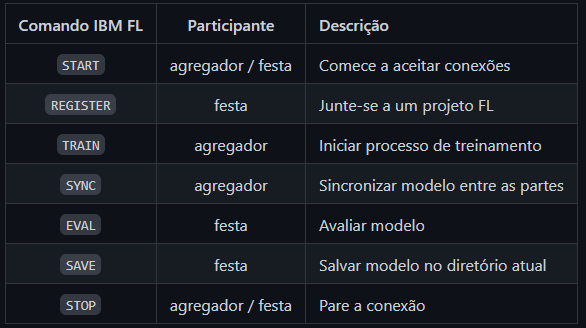

In [6]:
from ibmfl.aggregator.aggregator import Aggregator
aggregator = Aggregator(config_dict=agg_config)

aggregator.start()

2023-02-06 20:38:36,167 | 1.1.0 | INFO | ibmfl.util.config                             | Getting Aggregator details from arguments.
2023-02-06 20:38:36,177 | 1.1.0 | INFO | ibmfl.util.config                             | No metrics recorder config provided for this setup.
2023-02-06 20:38:36,179 | 1.1.0 | INFO | ibmfl.util.config                             | No model config provided for this setup.
2023-02-06 20:38:36,963 | 1.1.0 | INFO | ibmfl.util.config                             | No metrics config provided for this setup.
2023-02-06 20:38:36,965 | 1.1.0 | INFO | ibmfl.util.config                             | No evidencia recordeer config provided for this setup.
2023-02-06 20:38:36,971 | 1.1.0 | INFO | ibmfl.util.data_handlers.mnist_keras_data_handler | Loaded training data from examples/datasets/mnist.npz
2023-02-06 20:38:42,488 | 1.1.0 | INFO | ibmfl.connection.flask_connection             | RestSender initialized
2023-02-06 20:38:42,521 | 1.1.0 | INFO | ibmfl.aggregator.prot

# Iniciando treinamento

Para a realização do treinamento devemos a princípio inicializar as métricas de quantidade de participantes, acurácia e iterações. Em seguida, definimos métricas para a coleta de informações e por fim, após a conexão dos participantes se estabelecerem, iniciamos o treinamento. 

In [7]:
"""
#1 Initialize the metrics collector variables
"""
num_parties = agg_config['hyperparams']['global']['num_parties']
eval_party_accuracy = [[] for _ in range(num_parties)]
iterations = [[] for _ in range(num_parties)]

"""
#2 Register handler for metrics collector
"""
def get_metrics(metrics):
    keys = list(metrics['party'].keys())
    keys.sort()
    for i in range(len(keys)):
      eval_party_accuracy[i].append(metrics['party'][keys[i]]['acc'])
      iterations[i].append(metrics['fusion']['curr_round']*agg_config['hyperparams']['local']['training']['epochs'])
      
mh = aggregator.fusion.metrics_manager
mh.register(get_metrics)


"""
#3 start the training
"""
aggregator.start_training()

2023-02-06 20:39:39,293 | 1.1.0 | INFO | ibmfl.aggregator.aggregator                   | Initiating Global Training.
2023-02-06 20:39:39,296 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_handler        | Warm start disabled.
2023-02-06 20:39:39,305 | 1.1.0 | INFO | ibmfl.aggregator.fusion.iter_avg_fusion_handler | Model updateNone
2023-02-06 20:39:39,308 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.SND_MODEL
2023-02-06 20:39:39,310 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.SND_REQ
2023-02-06 20:39:40,454 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Total number of success responses :1
2023-02-06 20:39:40,464 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Number of parties queried:1
2023-02-06 20:39:40,465 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Number of registered parties:1
2023-02-06 20:39:40,469 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.p

/home/opc/miniconda3/envs/ibm_fl/lib/python3.6/site-packages/ibmfl/aggregator/fusion/iter_avg_fusion_handler.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  update = np.array(update.get(key))


2023-02-06 20:40:26,462 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.SND_MODEL
2023-02-06 20:40:26,473 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.SND_REQ
2023-02-06 20:40:28,569 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Total number of success responses :1
2023-02-06 20:40:28,573 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Number of parties queried:1
2023-02-06 20:40:28,576 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Number of registered parties:1
2023-02-06 20:40:28,578 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.QUORUM_WAIT
2023-02-06 20:40:33,651 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:5
2023-02-06 20:40:38,663 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:10
2023-02-06 20:40:43,672 | 1.1.0 | INFO | ibmfl.aggregator.protoha

2023-02-06 20:42:35,965 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:30
2023-02-06 20:42:35,969 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.PROC_RSP
2023-02-06 20:42:35,973 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.RCV_MODEL
2023-02-06 20:42:35,975 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.AGGREGATING
2023-02-06 20:42:35,987 | 1.1.0 | INFO | ibmfl.aggregator.fusion.iter_avg_fusion_handler | Model update<ibmfl.model.model_update.ModelUpdate object at 0x7f1c1b42a7b8>
2023-02-06 20:42:35,989 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.SND_MODEL
2023-02-06 20:42:35,993 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.SND_REQ
2023-02-06 20:42:36,352 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Total number of success responses :1
2023-02-06 

2023-02-06 20:44:18,088 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:25
2023-02-06 20:44:18,091 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.PROC_RSP
2023-02-06 20:44:18,095 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.RCV_MODEL
2023-02-06 20:44:18,096 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.AGGREGATING
2023-02-06 20:44:18,105 | 1.1.0 | INFO | ibmfl.aggregator.fusion.iter_avg_fusion_handler | Model update<ibmfl.model.model_update.ModelUpdate object at 0x7f1c1b42a7b8>
2023-02-06 20:44:18,110 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.SND_MODEL
2023-02-06 20:44:18,115 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.SND_REQ
2023-02-06 20:44:18,655 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Total number of success responses :1
2023-02-06 

2023-02-06 20:46:00,591 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:25
2023-02-06 20:46:00,595 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.PROC_RSP
2023-02-06 20:46:00,597 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.RCV_MODEL
2023-02-06 20:46:00,600 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.AGGREGATING
2023-02-06 20:46:00,657 | 1.1.0 | INFO | ibmfl.aggregator.fusion.iter_avg_fusion_handler | Model update<ibmfl.model.model_update.ModelUpdate object at 0x7f1c1b1459e8>
2023-02-06 20:46:00,660 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.SND_MODEL
2023-02-06 20:46:00,663 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.SND_REQ
2023-02-06 20:46:00,968 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Total number of success responses :1
2023-02-06 

2023-02-06 20:47:52,651 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:25
2023-02-06 20:47:53,371 | 1.1.0 | INFO | ibmfl.connection.flask_connection             | Request received for path :7
2023-02-06 20:47:53,657 | 1.1.0 | INFO | werkzeug                                      | 127.0.0.1 - - [06/Feb/2023 20:47:53] "POST /7 HTTP/1.1" 200 -
2023-02-06 20:47:57,655 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:30
2023-02-06 20:47:57,657 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.PROC_RSP
2023-02-06 20:47:57,662 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.RCV_MODEL
2023-02-06 20:47:57,664 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.AGGREGATING
2023-02-06 20:47:57,729 | 1.1.0 | INFO | ibmfl.aggregator.fusion.iter_avg_fusion_handler | Model update<ibmfl.model.model_update.ModelUpdate object at 

2023-02-06 20:49:41,772 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:20
2023-02-06 20:49:45,671 | 1.1.0 | INFO | ibmfl.connection.flask_connection             | Request received for path :7
2023-02-06 20:49:45,953 | 1.1.0 | INFO | werkzeug                                      | 127.0.0.1 - - [06/Feb/2023 20:49:45] "POST /7 HTTP/1.1" 200 -
2023-02-06 20:49:46,779 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:25
2023-02-06 20:49:46,781 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.PROC_RSP
2023-02-06 20:49:46,782 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.RCV_MODEL
2023-02-06 20:49:46,786 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.AGGREGATING
2023-02-06 20:49:46,960 | 1.1.0 | INFO | ibmfl.aggregator.fusion.iter_avg_fusion_handler | Model update<ibmfl.model.model_update.ModelUpdate object at 

2023-02-06 20:51:25,951 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:15
2023-02-06 20:51:30,957 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:20
2023-02-06 20:51:34,857 | 1.1.0 | INFO | ibmfl.connection.flask_connection             | Request received for path :7
2023-02-06 20:51:34,898 | 1.1.0 | INFO | werkzeug                                      | 127.0.0.1 - - [06/Feb/2023 20:51:34] "POST /7 HTTP/1.1" 200 -
2023-02-06 20:51:35,959 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:25
2023-02-06 20:51:35,961 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.PROC_RSP
2023-02-06 20:51:35,963 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.RCV_MODEL
2023-02-06 20:51:35,965 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.AGGREGATING
2023-02-06 20:51:36,042 | 1.1.0 | INF

2023-02-06 20:53:09,957 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:15
2023-02-06 20:53:14,967 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:20
2023-02-06 20:53:17,852 | 1.1.0 | INFO | ibmfl.connection.flask_connection             | Request received for path :7
2023-02-06 20:53:17,965 | 1.1.0 | INFO | werkzeug                                      | 127.0.0.1 - - [06/Feb/2023 20:53:17] "POST /7 HTTP/1.1" 200 -
2023-02-06 20:53:19,973 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Timeout:60 Time spent:25
2023-02-06 20:53:19,977 | 1.1.0 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.PROC_RSP
2023-02-06 20:53:19,981 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.RCV_MODEL
2023-02-06 20:53:19,983 | 1.1.0 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.AGGREGATING
2023-02-06 20:53:19,990 | 1.1.0 | INF

True

In [ ]:
"""
#1 define a method to plot a smooth cure
"""
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

def smooth_curve(xaxis, yaxis):
   xnew = np.linspace(min(xaxis), max(xaxis), len(xaxis)*50) 

   spl = make_interp_spline(xaxis, yaxis, k=1)  # type: BSpline
   power_smooth = spl(xnew)
   return xnew, power_smooth 

f = plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)

num_parties = agg_config['hyperparams']['global']['num_parties']


"""
#2 plot the evaluation curve
"""
for i in range(num_parties):
    eval_party_xaxis, eval_party_yaxis = smooth_curve(iterations[i], eval_party_accuracy[i])
    line1, = plt.plot(eval_party_xaxis, eval_party_yaxis)
    line1.set_label('party'+str(i+1))
plt.title('Evaluation Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Finalizando o treinamento

Por fim, devemos parar nosso agregador utilizando o comando **STOP**.

In [ ]:
aggregator.stop()